<a href="https://colab.research.google.com/github/cristopher-d-delgado/image_classification_pneumonia/blob/main/mlp_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection on Chest X-Rays

In [1]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

In [2]:
# # Google Drive connection

# from google.colab import drive
# drive.mount('/content/drive/')

# Explore our Data & Preprocess

In [3]:
import os
# Create a path to the root folder and path to specific folders on my computer
# data_path = '/content/drive/MyDrive/Flatiron/phase4/chest_xray/chest_xray'
data_path = 'data\chest_xray\chest_xray'
data_path

# Specificy paths for train, test, val
train_folder = os.path.join(data_path, 'train')
test_folder = os.path.join(data_path, 'test')
val_folder = os.path.join(data_path, 'val')

# Specify paths for labels
train_normal = os.path.join(train_folder, 'NORMAL')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, "NORMAL")
test_pneumonia = os.path.join(test_folder, "PNEUMONIA")
val_normal = os.path.join(val_folder, "NORMAL")
val_pneumonia = os.path.join(val_folder, "PNEUMONIA")

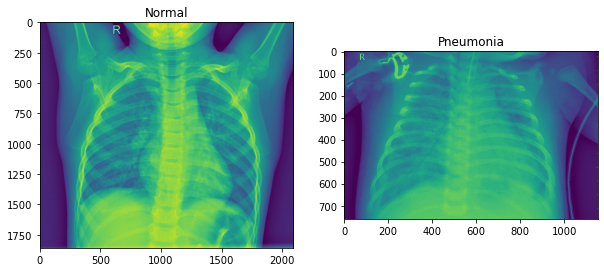

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Read images
# img1 = Image.open("/content/drive/MyDrive/Flatiron/phase4/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
# img2 = Image.open("/content/drive/MyDrive/Flatiron/phase4/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
img1 = Image.open("data/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
img2 = Image.open("data/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
# Display images side by side
plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Normal')

# Plot the second image
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Pneumonia')

plt.show()

It seems that the images are not actually on the same size. Visually we can see the bacterial infection. We would have to preprocess the images to become the same size and also lower the scale since training a neuwral network is resource intensive. Lets explore how many images we have in each directory.

In [5]:
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(test_normal)), 'normal images in the testing set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the testing set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 1342 normal images in the training set
There are 3876 pneumonia images in the training set
________________________________________________________________________________________
There are 234 normal images in the testing set
There are 390 pneumonia images in the testing set
________________________________________________________________________________________
There are 9 normal images in the validation set
There are 9 pneumonia images in the validation set


Lets preprocess the images by resizing to (128, 128, 3)

In [74]:
# Preprocess our Data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path for data folders
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Set the input size for images
img_size = (128, 128)

# Set up data generators for training, testing, and validation
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=200,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=64,
    class_mode='binary'
)

val_generator = datagen.flow_from_directory(
    val_data_dir,
    target_size=img_size,
    batch_size=2,
    class_mode='binary'
)

# Optionally, check the class indices assigned by Keras
print("Class indices:", train_generator.class_indices)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


In [109]:
from random import shuffle
import tensorflow

def process_data(img_dims, batch_size, train_data_dir, test_data_dir, val_data_dir):
    # Set up data generators for training, testing, and validation
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary', 
        shuffle=True
    )
    
    test_generator = test_val_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary', 
        shuffle=True
    )
    
    val_generator = test_val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary', 
        shuffle=True
    )
    
    # # Now that the generators are taken care of lets create labels for the test set so we can make a confusion matrix later on
    # test_data = []
    # test_labels = []

    # for cond in ['/NORMAL/', '/PNEUMONIA/']:
    #     for img in os.listdir(test_data_dir + cond):
    #         img_path = os.path.join(test_data_dir, cond, img)
            
    #         # Read and preprocess the image
    #         img = plt.imread(img_path)
    #         img = np.dstack([img, img, img])
    #         img = img.astype('float32') / 255
            
    #         # Resize the image to the desired dimensions
    #         img = tf.expand_dims(img, axis=0)  # Add an extra dimension
    #         img = tf.image.resize(img, [img_dims, img_dims])
            
    #         # Remove the extra dimension and append to the list
    #         img = tf.squeeze(img, axis=0)
    #         test_data.append(img.numpy())
    #         test_labels.append(cond)
        
    # test_data = np.array(test_data)
    # test_labels = np.array(test_labels)
    
    return train_generator, test_generator, val_generator, 
# test_data, test_labels

In [110]:
train_gen, test_gen, val_gen = process_data(150, 32, train_data_dir, test_data_dir, val_data_dir)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


It seems the generators are working as expected

Image dimensions: (150, 150, 3)


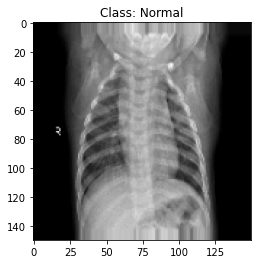

In [115]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first image
plt.imshow(images[0])
plt.title(f"Class: {'Normal' if labels[0] == 0 else 'Pneumonia'}")
plt.show()

We sucecssfully resized the images and also created an RGB tensor. Lets create our datasets

# Make an Multilayer Perceptrons Model

I don't expect great perfomance in comparison to a Convuluted Neural Network. For the sake of trying we should attempt a basic neural network before getting more complex using basic MLP layers

**Base MLP Model:**

Define Base Model

We can attempt to train the model by iterating over the numebr of epochs. We can then save look at the validation and training loss and see where it begins to overfit.

In [134]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import BinaryAccuracy, BinaryCrossentropy, Precision, Recall
import time

# Define metrics we want to log
METRICS = metrics=[
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]

# Define an optmizer
def get_optimizer():
    # According to Tensorflow documentation most models learn better if you gradually redice the learning rate during training. Lets attempt to reduce the leanring rate over time. 
    step = np.linspace(0,100000)
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001,
        decay_steps=step*1000,
        decay_rate=1,
        staircase=False
    )
    return tf.keras.optimizers.Adam(lr_schedule)

# Define our callbacks
def get_callbacks():
    # Initialize callbacks 
    return [
    EarlyStopping(monitor='val_loss', patience=5),
    TensorBoard(log_dir="logs", histogram_freq=1),
    ]



def train_model(model, train_generator, val_generator, total_epochs):
    """
    model = your compiled model
    name = log directory
    train_generator = train gen you make 
    val_generator = val gen you make as well 
    total_epochs = the number of epochs 
    
    ** There is a Tensorboard implementation in the callback which will save all our history which we can acces in the log directory. It is in the get_callbacks function
    """
    # Since we are in a medical standpoint we should look at these metrics as well
    METRICS = metrics=[
        BinaryAccuracy(),
        BinaryCrossentropy(),
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]
    
    # Record the start time for training all epoch range
    start_time = time.time()

    # Train the model for set epochs
    history = model.fit(x=train_generator, validation_data=val_generator, epochs=total_epochs, callbacks=get_callbacks())

    # Record the end time for the current epoch
    end_time = time.time()

    # Print the total training time
    total_training_time = end_time - start_time
    print(f"Total training time: {total_training_time} seconds")

    # Return the history
    return history.history

In [ ]:
import seaborn as sns
def view_history(dictionary, index):
    
    # Define font sizes
    font_label = 15
    font_title = 20 
    font_ticks = 12
    
    ## Plot the Loss vs Epoch graph
    plt.figure(figsize=(8,6))
    # Plot training loss
    sns.lineplot(x=np.arange(1, len(dictionary[index]['loss'])+1), y=dictionary[index]['loss'], label='Training Loss')
    # Plot validation loss
    sns.lineplot(x=np.arange(1, len(dictionary[index]['loss'])+1), y=dictionary[index]['val_loss'], label='Validation Loss')
    plt.title("Loss vs Epoch", fontsize=font_title)
    plt.xlabel('Epoch', fontsize=font_label)
    plt.ylabel('Loss', fontsize=font_label)
    plt.legend(fontsize=font_ticks)
    plt.show()
    
    ## Plot the Recall/Precision vs Epoch graph
    plt.figure(figsize=(8,6))
    # Plot Validation Recall
    sns.lineplot(x=np.arange(1, len(dictionary[index]['val_recall'])+1), y=dictionary[index]['val_recall'], label='Validation Recall')
    # Plot Train Recall
    sns.lineplot(x=np.arange(1, len(dictionary[index]['recall'])+1), y=dictionary[index]['recall'], label='Train Recall')
    # Plot Validation Precision
    sns.lineplot(x=np.arange(1, len(dictionary[index]['val_precision'])+1), y=dictionary[index]['val_precision'], label='Validation Precision')
    # Plot Train Precision
    sns.lineplot(x=np.arange(1, len(dictionary[index]['precision'])+1), y=dictionary[index]['precision'], label='Train Precision')
    
    
    plt.title("Validation/Train Recall & Precision vs Epoch", fontsize=font_title)
    plt.xlabel('Epoch', fontsize=font_label)
    plt.ylabel('Performance', fontsize=font_label)
    plt.legend(fontsize=font_ticks)
    plt.show()

In [119]:
import time
import pandas as pd
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam


# Define input shape
input_shape = (150, 150, 3)

# Define the basic model 
model_mlp_base = Sequential()

# Define the layers 
model_mlp_base.add(Flatten(input_shape=input_shape))
model_mlp_base.add(Dense(64, activation='relu', input_shape=input_shape))
model_mlp_base.add(Dense(1, activation='sigmoid'))
model_mlp_base.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 67500)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4320064   
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 65        
Total params: 4,320,129
Trainable params: 4,320,129
Non-trainable params: 0
_________________________________________________________________
None


In [121]:
base_1_history = {}
base_1_history['Version1'] = train_model(model_mlp_base, train_gen, val_gen, total_epochs=30)

Epoch 1/30
163/163 [==============================] - 52s 317ms/step - loss: 2.5493 - precision: 0.8062 - recall: 0.8041 - accuracy: 0.7109 - val_loss: 0.5626 - val_precision: 0.7500 - val_recall: 0.7500 - val_accuracy: 0.7500
Epoch 2/30
163/163 [==============================] - 49s 300ms/step - loss: 0.9259 - precision: 0.8604 - recall: 0.8668 - accuracy: 0.7966 - val_loss: 1.0561 - val_precision: 0.6667 - val_recall: 0.2500 - val_accuracy: 0.5625
Epoch 3/30
163/163 [==============================] - 48s 293ms/step - loss: 1.1051 - precision: 0.8639 - recall: 0.8601 - accuracy: 0.7954 - val_loss: 0.5554 - val_precision: 0.8000 - val_recall: 1.0000 - val_accuracy: 0.8750
Epoch 4/30
163/163 [==============================] - 49s 300ms/step - loss: 0.5554 - precision: 0.8879 - recall: 0.8932 - accuracy: 0.8368 - val_loss: 0.3294 - val_precision: 0.8889 - val_recall: 1.0000 - val_accuracy: 0.9375
Epoch 5/30
163/163 [==============================] - 49s 303ms/step - loss: 0.7774 - precis

In [122]:
print(base_1_history['Version1'].keys())

dict_keys(['loss', 'precision', 'recall', 'accuracy', 'val_loss', 'val_precision', 'val_recall', 'val_accuracy'])


In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def view_history(dictionary, index):
    
    # Define font sizes
    font_label = 15
    font_title = 20 
    font_ticks = 12
    
    # Make Subplots
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    ax = ax.ravel()
    
    ## Plot the Loss vs Epoch graph
    ax[0].plot(np.arange(1, len(dictionary[index]['loss'])+1), dictionary[index]['loss'], label='Training Loss')
    ax[0].plot(np.arange(1, len(dictionary[index]['val_loss'])+1), dictionary[index]['val_loss'], label='Validation Loss')
    ax[0].set_title("Loss vs Epoch", fontsize=font_title)
    ax[0].set_xlabel('Epoch', fontsize=font_label)
    ax[0].set_ylabel('Loss', fontsize=font_label)
    ax[0].legend(fontsize=font_ticks)
    
    ## Plot the Validation Recall/Precision vs Epoch graph
    ax[1].plot(np.arange(1, len(dictionary[index]['val_recall'])+1), dictionary[index]['val_recall'], label='Validation Recall')
    ax[1].plot(np.arange(1, len(dictionary[index]['val_precision'])+1), dictionary[index]['val_precision'], label='Validation Precision')
    ax[1].set_title("Validation Recall & Precision vs Epoch", fontsize=font_title)
    ax[1].set_xlabel('Epoch', fontsize=font_label)
    ax[1].set_ylabel('Performance', fontsize=font_label)
    ax[1].legend(fontsize=font_ticks)
    
    ## Plot the Train Recall/Precision vs Epoch graph
    ax[2].plot(np.arange(1, len(dictionary[index]['recall'])+1), dictionary[index]['recall'], label='Train Recall')
    ax[2].plot(np.arange(1, len(dictionary[index]['precision'])+1), dictionary[index]['precision'], label='Train Precision')
    ax[2].set_title("Train Recall & Precision vs Epoch", fontsize=font_title)
    ax[2].set_xlabel('Epoch', fontsize=font_label)
    ax[2].set_ylabel('Performance', fontsize=font_label)
    ax[2].legend(fontsize=font_ticks)
    
    ## Plot the Accuracies vs Epoch graph
    ax[3].plot(np.arange(1, len(dictionary[index]['accuracy'])+1), dictionary[index]['accuracy'], label='Train Accuracy')
    ax[3].plot(np.arange(1, len(dictionary[index]['val_accuracy'])+1), dictionary[index]['val_accuracy'], label='Validation Accuracy')
    ax[3].set_title("Accuracy vs Epoch", fontsize=font_title)
    ax[3].set_xlabel('Epoch', fontsize=font_label)
    ax[3].set_ylabel('Performance', fontsize=font_label)
    ax[3].legend(fontsize=font_ticks)
    
    plt.tight_layout()
    plt.show()


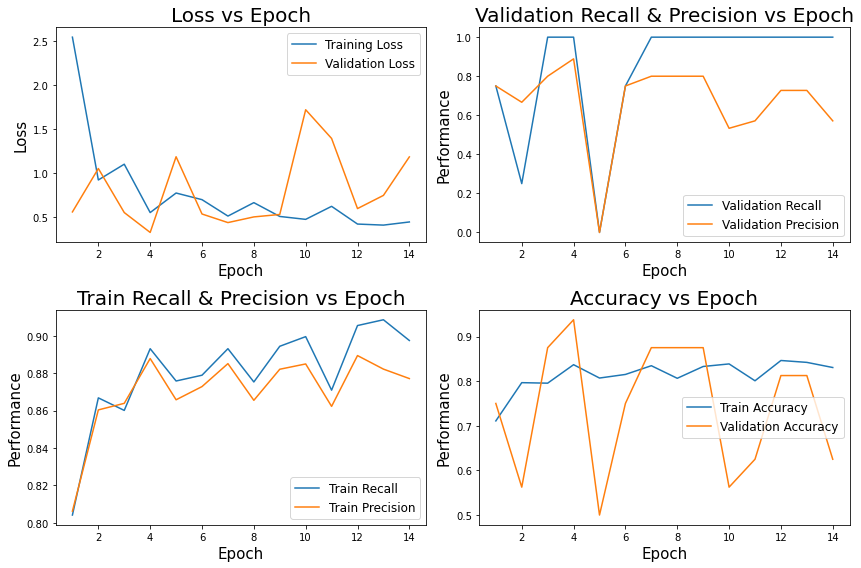

In [133]:
view_history(base_1_history, 'Version1')

In [138]:
def model_evaluate(model, train_gen, test_gen, val_gen):
    columns = ['Set', 'Loss', 'Precision', 'Recall', 'Accuracy']
    results = pd.DataFrame(columns=columns)
    
    # Evaluate on the training set
    train_results = model.evaluate(train_gen)
    train_metrics = ['Train'] + train_results[:]
    results = results.append(dict(zip(columns, train_metrics)), ignore_index=True)
    
    # Evaluate on the test set
    test_results = model.evaluate(test_gen)
    test_metrics = ['Test'] + test_results[:]
    results = results.append(dict(zip(columns, test_metrics)), ignore_index=True)
    
    # Evaluate on the validation set
    validation_results = model.evaluate(val_gen)
    val_metrics = ['Validation'] + validation_results[:]
    results = results.append(dict(zip(columns, val_metrics)), ignore_index=True)
    
    # Lets modify the Precision, Recall, Accuracy to percentages
    results['Precision'] = results['Precision']*100
    results['Recall'] = results['Recall']*100
    results['Accuracy'] = results['Accuracy']*100
    
    return results

In [139]:
model_evaluate(model_mlp_base, train_gen, test_gen, val_gen)

1/1 [==============================] - 0s 998us/step - loss: 1.1881 - precision: 0.5714 - recall: 1.0000 - accuracy: 0.6250


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.407033,84.300643,97.832257,84.854293
1,Test,0.538780,76.767677,97.435898,79.967946
2,Validation,1.188068,57.142860,100.000000,62.500000


We can tell we are underfitting as our validation loss seems to be noisy. Our training loss continues to decrease while this occurs. The gaps between training and validation loss suggets that noise is happening. Lets make the model more complex with another dense layer 

# MLP Version 2

In [140]:
# Define input shape
input_shape = (150, 150, 3)

# Define the basic model 
model_mlp_base_2 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_2.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_2.add(Dense(64, activation='relu'))
model_mlp_base_2.add(Dense(16, activation='relu'))

# Define output layer
model_mlp_base_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_2.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 67500)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                4320064   
_________________________________________________________________
dense_37 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 17        
Total params: 4,321,121
Trainable params: 4,321,121
Non-trainable params: 0
_________________________________________________________________
None


In [141]:
# Update our dictionary with Version 2
base_1_history['Version2'] = train_model(model_mlp_base_2, train_gen, val_gen, total_epochs=30)

Epoch 1/30
163/163 [==============================] - 51s 312ms/step - loss: 0.8088 - precision: 0.8191 - recall: 0.8516 - accuracy: 0.7500 - val_loss: 1.5602 - val_precision: 0.5714 - val_recall: 1.0000 - val_accuracy: 0.6250
Epoch 2/30
163/163 [==============================] - 48s 291ms/step - loss: 0.4058 - precision: 0.8729 - recall: 0.9061 - accuracy: 0.8322 - val_loss: 0.6807 - val_precision: 0.6667 - val_recall: 1.0000 - val_accuracy: 0.7500
Epoch 3/30
163/163 [==============================] - 49s 301ms/step - loss: 0.4305 - precision: 0.8662 - recall: 0.9019 - accuracy: 0.8236 - val_loss: 0.6943 - val_precision: 0.6667 - val_recall: 0.5000 - val_accuracy: 0.6250
Epoch 4/30
163/163 [==============================] - 49s 298ms/step - loss: 0.4674 - precision: 0.8631 - recall: 0.8870 - accuracy: 0.8115 - val_loss: 1.3865 - val_precision: 0.5714 - val_recall: 1.0000 - val_accuracy: 0.6250
Epoch 5/30
163/163 [==============================] - 49s 300ms/step - loss: 0.3784 - precis

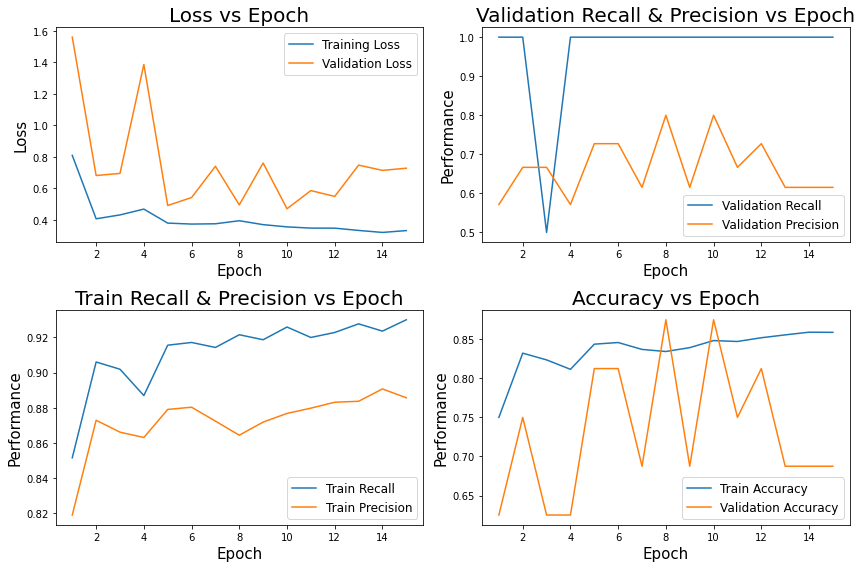

In [142]:
# Visualize the history 
view_history(base_1_history, 'Version2')

In [143]:
# Evaluate the model
model_evaluate(model_mlp_base_2, train_gen, test_gen, val_gen)

1/1 [==============================] - 0s 994us/step - loss: 0.7274 - precision: 0.6154 - recall: 1.0000 - accuracy: 0.6875


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.312938,86.000454,97.496772,86.349696
1,Test,0.400868,79.741377,94.871795,81.730771
2,Validation,0.727367,61.538464,100.000000,68.750000


It seems that adding another layer helped generalize more. It generally does follow closely up until epoch 12 where the validation loss increases while train loss decreases suggesting overfit. We can attempt to add some regularization to the layers.

# MLP Version 3

In [144]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (150, 150, 3)

# Define the basic model 
model_mlp_base_3 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_3.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_3.add(Dense(64, activation='relu', kernel_regularizer=l2()))
model_mlp_base_3.add(Dense(16, activation='relu', kernel_regularizer=l2()))

# Define output layer
model_mlp_base_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_3.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_3.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 67500)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                4320064   
_________________________________________________________________
dense_40 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 17        
Total params: 4,321,121
Trainable params: 4,321,121
Non-trainable params: 0
_________________________________________________________________
None


In [145]:
# Update our dictionary with Version 2
base_1_history['Version3'] = train_model(model_mlp_base_3, train_gen, val_gen, total_epochs=30)

Epoch 1/30
163/163 [==============================] - 51s 312ms/step - loss: 2.2888 - precision: 0.7929 - recall: 0.8262 - accuracy: 0.7109 - val_loss: 2.2828 - val_precision: 0.5333 - val_recall: 1.0000 - val_accuracy: 0.5625
Epoch 2/30
163/163 [==============================] - 49s 303ms/step - loss: 0.7627 - precision: 0.8491 - recall: 0.8973 - accuracy: 0.8052 - val_loss: 0.9043 - val_precision: 0.6667 - val_recall: 0.2500 - val_accuracy: 0.5625
Epoch 3/30
163/163 [==============================] - 49s 302ms/step - loss: 0.6497 - precision: 0.8496 - recall: 0.8908 - accuracy: 0.8018 - val_loss: 1.1274 - val_precision: 0.5714 - val_recall: 1.0000 - val_accuracy: 0.6250
Epoch 4/30
163/163 [==============================] - 50s 309ms/step - loss: 0.5023 - precision: 0.8657 - recall: 0.9151 - accuracy: 0.8315 - val_loss: 0.6545 - val_precision: 0.7273 - val_recall: 1.0000 - val_accuracy: 0.8125
Epoch 5/30
163/163 [==============================] - 50s 304ms/step - loss: 0.4737 - precis

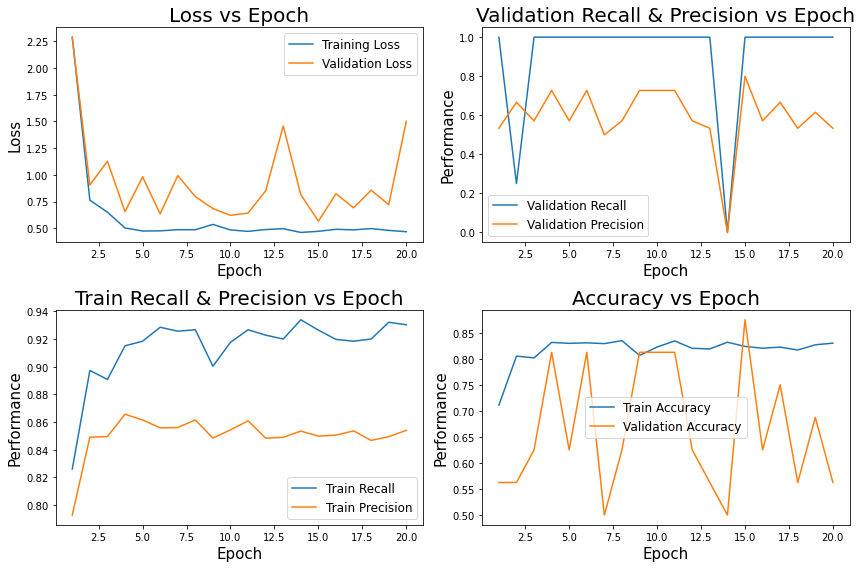

In [148]:
# Visualize the history 
view_history(base_1_history, 'Version3')

In [149]:
# Evaluate the model
model_evaluate(model_mlp_base_3, train_gen, test_gen, val_gen)

1/1 [==============================] - 0s 1ms/step - loss: 1.5010 - precision: 0.5333 - recall: 1.0000 - accuracy: 0.5625


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.736106,75.170004,99.845159,75.383437
1,Test,0.982785,62.700963,100.000000,62.820512
2,Validation,1.500984,53.333336,100.000000,56.250000


This is interesting. So the training and validation followed eachother closely up to 3 epochs. After that they stay diverged but are much closer in general in comparison to our other mlp models. This means that we are generalizing better but not enough since we still have major spikes. We can add Dropout layers and see the impact

# MLP Version 4

# Convolutional Neural Network


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
# Define the model
model_cnn_1 = Sequential()

# Add Convolutional Layer to look more for local features
model_cnn_1.add(Conv2D(32, kernel_size=(2,2), activation='relu', input_shape=(128, 128, 3)))

# Add Pooling Layer
model_cnn_1.add(MaxPooling2D((2, 2)))

# Add Convolutional Layer to look more for global features
model_cnn_1.add(Conv2D(32, (4, 4), activation='relu'))

# Add Second Pooling Layer
model_cnn_1.add(MaxPooling2D((2, 2)))

# Add a third Convolutional Layer to look more for global features
model_cnn_1.add(Conv2D(32, (6, 6), activation='relu'))

# Add Pooling Layer
model_cnn_1.add(MaxPooling2D((2, 2)))

# Add a Flatten Layer to prepare data for fully connected layers
model_cnn_1.add(Flatten())

# Add Dense layer with relu
model_cnn_1.add(Dense(64, activation='relu'))

# Add Dense layer with sigmoid for binary classification
model_cnn_1.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

print(model_cnn_1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 127, 127, 32)      416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 32)        16416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 32)        36896     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)             

In [15]:
cnn_1 = train_model_and_get_epoch_data(model_cnn_1, train_generator, val_generator, total_epochs=80, save_history_path="cnn_1_history.npy")
print(cnn_1)

Epoch 1/80
82/82 [==============================] - 107s 1s/step - loss: 0.3389 - accuracy: 0.8484 - val_loss: 0.4651 - val_accuracy: 0.8750
Epoch 2/80
82/82 [==============================] - 55s 673ms/step - loss: 0.1209 - accuracy: 0.9548 - val_loss: 0.4645 - val_accuracy: 0.7500
Epoch 3/80
82/82 [==============================] - 54s 665ms/step - loss: 0.1061 - accuracy: 0.9592 - val_loss: 0.4574 - val_accuracy: 0.8125
Epoch 4/80
82/82 [==============================] - 55s 668ms/step - loss: 0.0838 - accuracy: 0.9682 - val_loss: 0.5694 - val_accuracy: 0.6875
Epoch 5/80
82/82 [==============================] - 54s 664ms/step - loss: 0.0743 - accuracy: 0.9716 - val_loss: 0.2200 - val_accuracy: 0.8750
Epoch 6/80
82/82 [==============================] - 54s 662ms/step - loss: 0.0605 - accuracy: 0.9785 - val_loss: 0.3510 - val_accuracy: 0.8750
Epoch 7/80
82/82 [==============================] - 54s 653ms/step - loss: 0.0572 - accuracy: 0.9781 - val_loss: 0.3708 - val_accuracy: 0.7500
E

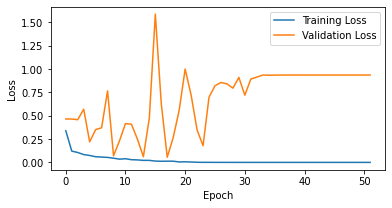

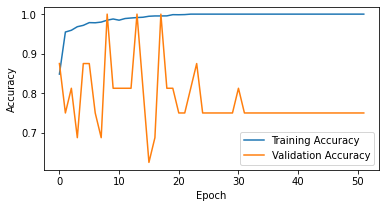

In [18]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the training history
loaded_history = np.load('models/cnn_1_history.npy', allow_pickle=True).item()

# Plot the training loss and validation loss
plt.figure(figsize=(6,3))
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(6,3))
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
results_train = model_cnn_1.evaluate(train_generator)
results_test = model_cnn_1.evaluate(test_generator)

10/10 [==============================] - 9s 868ms/step - loss: 0.6837 - accuracy: 0.6154


In [24]:
results_train

[0.6680111289024353, 0.7315950989723206]

In [25]:
results_test

[0.68365079164505, 0.6153846383094788]

The graph shows that the model is overfitting. This is because the training loss is decreasing while the validation loss is increasing. This means that the model is learning the training data too well and is not generalizing well to new data.

In comparison to our simple MLP model we are now capturing more of the data features but now there is so much noise. 

This can be due to too many layers. We can see after 30 epochs the loss is just flat suggesting a very bad over fit. Lets attempt to reduce model complexity by reducing the number of layers or neurons.

## CNN_2

Lets reduce the complexity by reducing the Conv2D layers from 32 filter to 16 and 8. Lets end the neural network with a single Dense layer of one neuron for binary classification. Lets see if we reduce overfit this way

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
# Define the model
model_cnn_2 = Sequential()

# Add Convolutional Layer to look more for local features
model_cnn_2.add(Conv2D(16, kernel_size=(2,2), activation='relu', input_shape=(128, 128, 3)))

# Add Pooling Layer
model_cnn_2.add(MaxPooling2D((2, 2)))

# Add Convolutional Layer to look more for global features
model_cnn_2.add(Conv2D(8, (4, 4), activation='relu'))

# Add Second Pooling Layer
model_cnn_2.add(MaxPooling2D((2, 2)))

# Add a Flatten Layer to prepare data for fully connected layers
model_cnn_2.add(Flatten())

# Add Dense layer with relu
model_cnn_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

print(model_cnn_2.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 127, 127, 16)      208       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 8)         2056      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7201      
Total params: 9,465
Trainable params: 9,465
Non-trainable params: 0
____________________________________________________

In [21]:
cnn_2 = train_model_and_get_epoch_data(model_cnn_2, train_generator, val_generator, total_epochs=30, save_history_path="cnn_2_history.npy")
print(cnn_2)

Epoch 1/30
82/82 [==============================] - 91s 1s/step - loss: 0.3702 - accuracy: 0.8311 - val_loss: 0.6765 - val_accuracy: 0.6250
Epoch 2/30
82/82 [==============================] - 41s 505ms/step - loss: 0.1387 - accuracy: 0.9511 - val_loss: 0.5521 - val_accuracy: 0.7500
Epoch 3/30
82/82 [==============================] - 41s 500ms/step - loss: 0.1051 - accuracy: 0.9620 - val_loss: 0.5828 - val_accuracy: 0.6875
Epoch 4/30
82/82 [==============================] - 41s 495ms/step - loss: 0.0897 - accuracy: 0.9664 - val_loss: 0.2122 - val_accuracy: 0.9375
Epoch 5/30
82/82 [==============================] - 42s 510ms/step - loss: 0.0861 - accuracy: 0.9709 - val_loss: 0.7844 - val_accuracy: 0.6875
Epoch 6/30
82/82 [==============================] - 40s 491ms/step - loss: 0.0764 - accuracy: 0.9712 - val_loss: 0.3244 - val_accuracy: 0.8750
Epoch 7/30
82/82 [==============================] - 41s 501ms/step - loss: 0.0670 - accuracy: 0.9735 - val_loss: 0.2522 - val_accuracy: 0.9375
Ep

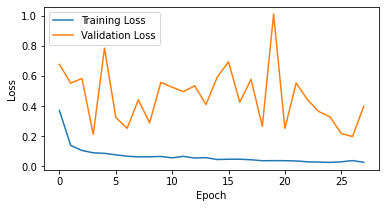

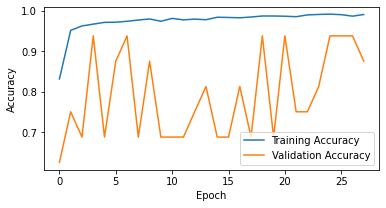

In [22]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the training history
loaded_history = np.load('models/cnn_2_history.npy', allow_pickle=True).item()

# Plot the training loss and validation loss
plt.figure(figsize=(6,3))
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(6,3))
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
results_train = model_cnn_2.evaluate(train_generator)
results_test = model_cnn_2.evaluate(test_generator)

10/10 [==============================] - 3s 346ms/step - loss: 1.4046 - accuracy: 0.7420


In [27]:
results_train

[0.018508831039071083, 0.9952070713043213]

In [28]:
results_test

[1.4045616388320923, 0.7419871687889099]

The graph shows that the model is overfitting. This is because the training loss is consistently lower than the validation loss, and the validation loss is increasing while the training loss is decreasing. This suggests that the model is not generalizing well to new data.

Eventhough we have a cnn network it doesnt do that much better than the basic mlp network. We might have to consider data augmentation and regularization or dropouts for the cnn

# CNN 3

Before any data augmentation lets attempt regularization between the layers using L2 regularization. Lets combine it using Dropout layers

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Define the model
model_cnn_3 = Sequential()

# Add Convolutional Layer to look more for local features
model_cnn_3.add(Conv2D(16, kernel_size=(2,2), activation='relu', input_shape=(128, 128, 3)))
# Add Pooling Layer
model_cnn_3.add(MaxPooling2D((2, 2)))
# Add dropout
model_cnn_3.add(Dropout(0.25))

# Add Convolutional Layer to look more for global features
model_cnn_3.add(Conv2D(8, (4, 4), activation='relu'))
# Add Second Pooling Layer
model_cnn_3.add(MaxPooling2D((2, 2)))
# Add dropout
model_cnn_3.add(Dropout(0.25))

# Add a Flatten Layer to prepare data for fully connected layers
model_cnn_3.add(Flatten())

# Add Dense layer with relu
model_cnn_3.add(Dense(1, activation='sigmoid',  kernel_regularizer=regularizers.l2(0.01)))
model_cnn_3.add(Dropout(0.5))

# Compile the model
model_cnn_3.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

print(model_cnn_3.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 127, 127, 16)      208       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 60, 60, 8)         2056      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 30, 30, 8)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 30, 8)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 7200)             

In [32]:
cnn_3 = train_model_and_get_epoch_data(model_cnn_3, train_generator, val_generator, total_epochs=30, save_history_path="cnn_3_history.npy")
print(cnn_3)

Epoch 1/30
82/82 [==============================] - 42s 513ms/step - loss: 5.8963 - accuracy: 0.4981 - val_loss: 0.5914 - val_accuracy: 0.8125
Epoch 2/30
82/82 [==============================] - 42s 507ms/step - loss: 6.0490 - accuracy: 0.5550 - val_loss: 0.5356 - val_accuracy: 0.8125
Epoch 3/30
82/82 [==============================] - 41s 495ms/step - loss: 6.0288 - accuracy: 0.5821 - val_loss: 0.5008 - val_accuracy: 0.8125
Epoch 4/30
82/82 [==============================] - 41s 496ms/step - loss: 5.7711 - accuracy: 0.6045 - val_loss: 0.4410 - val_accuracy: 0.7500
Epoch 5/30
82/82 [==============================] - 42s 512ms/step - loss: 5.8600 - accuracy: 0.5740 - val_loss: 0.5307 - val_accuracy: 0.8125
Epoch 6/30
82/82 [==============================] - 42s 510ms/step - loss: 5.9000 - accuracy: 0.5985 - val_loss: 0.4536 - val_accuracy: 0.8125
Epoch 7/30
82/82 [==============================] - 42s 506ms/step - loss: 5.7700 - accuracy: 0.5780 - val_loss: 0.4825 - val_accuracy: 0.8125

In [33]:
results_train = model_cnn_3.evaluate(train_generator)
results_test = model_cnn_3.evaluate(test_generator)

10/10 [==============================] - 3s 342ms/step - loss: 0.4358 - accuracy: 0.8494


In [34]:
results_train

[0.35500532388687134, 0.9027990698814392]

In [35]:
results_test

[0.4358387887477875, 0.8493589758872986]

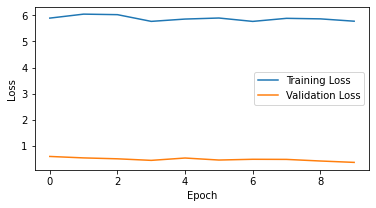

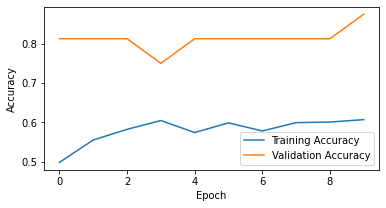

In [36]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the training history
loaded_history = np.load('models/cnn_3_history.npy', allow_pickle=True).item()

# Plot the training loss and validation loss
plt.figure(figsize=(6,3))
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(6,3))
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The graph shows that the model is underfitting. This is because the training loss and validation loss are both decreasing and the gap between them is small. This suggests that the model is not learning from the data as well as it could be.

Adding regularization helped but now we are underfitting. We need to remove a regularization step and attempt a 2nd iteration of this and see how it performs. If not add more layers that have dropout in addition to ConV2D

# CNN 4

First start by just removing the regularization on the single neuron at the end

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Define the model
model_cnn_4 = Sequential()

# Add Convolutional Layer to look more for local features
model_cnn_4.add(Conv2D(16, kernel_size=(2,2), activation='relu', input_shape=(128, 128, 3)))
# Add Pooling Layer
model_cnn_4.add(MaxPooling2D((2, 2)))
# Add dropout
model_cnn_4.add(Dropout(0.25))

# Add Convolutional Layer to look more for global features
model_cnn_4.add(Conv2D(8, (4, 4), activation='relu'))
# Add Second Pooling Layer
model_cnn_4.add(MaxPooling2D((2, 2)))
# Add dropout
model_cnn_4.add(Dropout(0.25))

# Add a Flatten Layer to prepare data for fully connected layers
model_cnn_4.add(Flatten())

# Add Dense layer with relu
model_cnn_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_4.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

print(model_cnn_4.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 127, 127, 16)      208       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 60, 60, 8)         2056      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 30, 30, 8)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 30, 30, 8)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 7200)             

In [45]:
cnn_4 = train_model_and_get_epoch_data(model_cnn_4, train_generator, val_generator, total_epochs=30, save_history_path="cnn_4_history.npy")
print(cnn_4)

Epoch 1/30
82/82 [==============================] - 41s 501ms/step - loss: 0.4655 - accuracy: 0.7797 - val_loss: 0.8444 - val_accuracy: 0.6250
Epoch 2/30
82/82 [==============================] - 41s 505ms/step - loss: 0.1984 - accuracy: 0.9224 - val_loss: 0.5286 - val_accuracy: 0.6875
Epoch 3/30
82/82 [==============================] - 42s 516ms/step - loss: 0.1471 - accuracy: 0.9436 - val_loss: 0.8881 - val_accuracy: 0.6250
Epoch 4/30
82/82 [==============================] - 42s 514ms/step - loss: 0.1230 - accuracy: 0.9528 - val_loss: 0.4275 - val_accuracy: 0.6875
Epoch 5/30
82/82 [==============================] - 42s 509ms/step - loss: 0.1052 - accuracy: 0.9607 - val_loss: 0.2869 - val_accuracy: 0.8750
Epoch 6/30
82/82 [==============================] - 42s 517ms/step - loss: 0.0967 - accuracy: 0.9641 - val_loss: 0.3149 - val_accuracy: 0.8125
Epoch 7/30
82/82 [==============================] - 41s 501ms/step - loss: 0.0948 - accuracy: 0.9636 - val_loss: 0.2729 - val_accuracy: 0.8125

In [46]:
results_train = model_cnn_4.evaluate(train_generator)
results_test = model_cnn_4.evaluate(test_generator)

10/10 [==============================] - 8s 841ms/step - loss: 1.2936 - accuracy: 0.7452


In [47]:
results_train

[0.02428414672613144, 0.9930981397628784]

In [48]:
results_test

[1.293623685836792, 0.745192289352417]

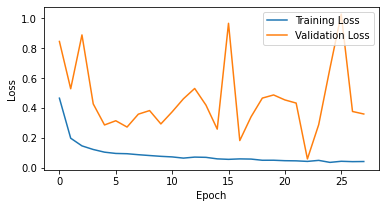

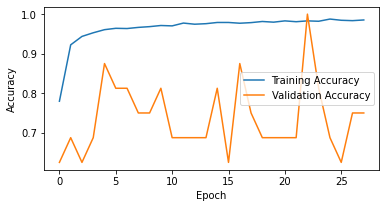

In [49]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the training history
loaded_history = np.load('models/cnn_4_history.npy', allow_pickle=True).item()

# Plot the training loss and validation loss
plt.figure(figsize=(6,3))
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(6,3))
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The graph shows that the model is underfitting. This is because the training loss and validation loss are both decreasing and the gap between them is small. This suggests that the model is not capturing the complexity of the data and is not able to generalize well to new data. Adding on we still have a bunch of spikes/noise. 

We should try adding more ConV layers and Dropout 

# CNN 5

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Define the model
model_cnn_5 = Sequential()

# Add Convolutional Layer to look more for local features
model_cnn_5.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 3)))
# Add Pooling Layer
model_cnn_5.add(MaxPooling2D((2, 2)))
# Add dropout
model_cnn_5.add(Dropout(0.2))

# Add Convolutional Layer to look more for global features
model_cnn_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
# Add Second Pooling Layer
model_cnn_5.add(MaxPooling2D((2, 2)))
# Add dropout
model_cnn_5.add(Dropout(0.2))
# Add Convolutional Layer to look for more for global features
model_cnn_5.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))

# Add a Flatten Layer to prepare data for fully connected layers, Add Dense layer and Dropout
model_cnn_5.add(Flatten())
model_cnn_5.add(Dense(64, activation='relu'))
model_cnn_5.add(Dropout(0.5))

# Add Dense layer with 1 neuron for binary classification
model_cnn_5.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_5.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

print(model_cnn_5.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 64)      

In [52]:
cnn_5 = train_model_and_get_epoch_data(model_cnn_5, train_generator, val_generator, total_epochs=20, save_history_path="cnn_5_history.npy")
print(cnn_5)

Epoch 1/20
82/82 [==============================] - 47s 573ms/step - loss: 0.6129 - accuracy: 0.7379 - val_loss: 0.6415 - val_accuracy: 0.5000
Epoch 2/20
82/82 [==============================] - 44s 536ms/step - loss: 0.3174 - accuracy: 0.8554 - val_loss: 0.6699 - val_accuracy: 0.5000
Epoch 3/20
82/82 [==============================] - 45s 550ms/step - loss: 0.2518 - accuracy: 0.9214 - val_loss: 0.6687 - val_accuracy: 0.6875
Epoch 4/20
82/82 [==============================] - 46s 557ms/step - loss: 0.1929 - accuracy: 0.9415 - val_loss: 0.5273 - val_accuracy: 0.6875
Epoch 5/20
82/82 [==============================] - 45s 550ms/step - loss: 0.1808 - accuracy: 0.9473 - val_loss: 0.4268 - val_accuracy: 0.7500
Epoch 6/20
82/82 [==============================] - 45s 547ms/step - loss: 0.1705 - accuracy: 0.9507 - val_loss: 0.2826 - val_accuracy: 0.8750
Epoch 7/20
82/82 [==============================] - 46s 563ms/step - loss: 0.1571 - accuracy: 0.9565 - val_loss: 0.3108 - val_accuracy: 0.8750

In [54]:
results_train = model_cnn_5.evaluate(train_generator)
results_test = model_cnn_5.evaluate(test_generator)
print('loss train:', results_train[0])
print('accuracy train:', results_train[1])
print('accuracy test:', results_test[0])
print('loss test:', results_test[1])

10/10 [==============================] - 3s 349ms/step - loss: 1.4682 - accuracy: 0.7917
loss train: 0.04080002382397652
accuracy train: 0.9886886477470398
accuracy test: 1.468174934387207
loss test: 0.7916666865348816


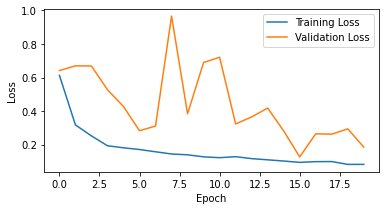

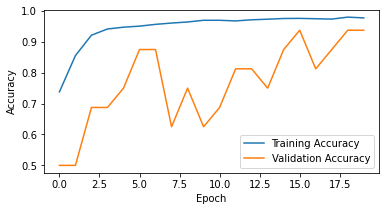

In [55]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the training history
loaded_history = np.load('models/cnn_5_history.npy', allow_pickle=True).item()

# Plot the training loss and validation loss
plt.figure(figsize=(6,3))
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(6,3))
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It seems that we are still underfitting. The losses are much closer now which is good. Lets add another ConV 2D layer with dropout again.

# CNN 6

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Define the model
model_cnn_6 = Sequential()

# Add Convolutional Layer to look more for local features
model_cnn_6.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 3)))
# Add Pooling Layer
model_cnn_6.add(MaxPooling2D((2, 2)))
# Add dropout
model_cnn_6.add(Dropout(0.2))

# Add Convolutional Layer to look more for global features
model_cnn_6.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
# Add Second Pooling Layer
model_cnn_6.add(MaxPooling2D((2, 2)))
# Add dropout
model_cnn_6.add(Dropout(0.2))

# Add Convolutional Layer to look for more for global features
model_cnn_6.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# Add Third Pooling Layer
model_cnn_6.add(MaxPooling2D((2, 2)))
# Add dropout
model_cnn_6.add(Dropout(0.2))

# Add Convolutional Layer to look for more for global features
model_cnn_6.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# Add fourth Pooling Layer
model_cnn_6.add(MaxPooling2D((2, 2)))
# Add dropout
model_cnn_6.add(Dropout(0.2))

# Add a Flatten Layer to prepare data for fully connected layers, Add Dense layer and Dropout
model_cnn_6.add(Flatten())
model_cnn_6.add(Dense(64, activation='relu'))
model_cnn_6.add(Dropout(0.5))

# Add Dense layer with 1 neuron for binary classification
model_cnn_6.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_6.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

print(model_cnn_6.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 28, 28, 64)      

In [58]:
cnn_6 = train_model_and_get_epoch_data(model_cnn_6, train_generator, val_generator, total_epochs=20, save_history_path="cnn_6_history.npy")
print(cnn_6)

Epoch 1/20
82/82 [==============================] - 45s 550ms/step - loss: 0.5338 - accuracy: 0.7483 - val_loss: 0.6555 - val_accuracy: 0.5625
Epoch 2/20
82/82 [==============================] - 46s 566ms/step - loss: 0.3211 - accuracy: 0.8368 - val_loss: 0.8668 - val_accuracy: 0.5625
Epoch 3/20
82/82 [==============================] - 44s 533ms/step - loss: 0.2495 - accuracy: 0.8980 - val_loss: 0.8356 - val_accuracy: 0.7500
Epoch 4/20
82/82 [==============================] - 45s 548ms/step - loss: 0.1913 - accuracy: 0.9239 - val_loss: 0.6930 - val_accuracy: 0.6875
Epoch 5/20
82/82 [==============================] - 46s 556ms/step - loss: 0.1723 - accuracy: 0.9371 - val_loss: 0.6892 - val_accuracy: 0.8125
Epoch 6/20
82/82 [==============================] - 46s 557ms/step - loss: 0.1524 - accuracy: 0.9438 - val_loss: 0.4744 - val_accuracy: 0.8125
Epoch 7/20
82/82 [==============================] - 46s 556ms/step - loss: 0.1522 - accuracy: 0.9469 - val_loss: 0.5016 - val_accuracy: 0.8125

In [60]:
results_train = model_cnn_6.evaluate(train_generator)
results_test = model_cnn_6.evaluate(test_generator)
results_val = model_cnn_6.evaluate(val_generator)
print('loss train:', results_train[0])
print('accuracy train:', results_train[1])
print('accuracy test:', results_test[0])
print('loss test:', results_test[1])
print('accuracy test:', results_val[0])
print('loss test:', results_val[1])

4/4 [==============================] - 0s 18ms/step - loss: 0.2302 - accuracy: 0.8750
loss train: 0.04480190947651863
accuracy train: 0.9867714643478394
accuracy test: 0.8996760249137878
loss test: 0.7596153616905212
accuracy test: 0.23023530840873718
loss test: 0.875


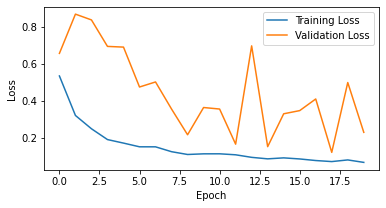

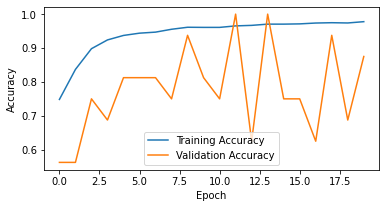

In [61]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the training history
loaded_history = np.load('models/cnn_6_history.npy', allow_pickle=True).item()

# Plot the training loss and validation loss
plt.figure(figsize=(6,3))
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(6,3))
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We have a lot less spies on the loss graph. We are capturing more of the data which is good. Lets add morer layers with more drops. Specifically more dense layers so we can smooth out the spikes 

# CNN 7

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, BinaryCrossentropy
#from tensorflow.keras.losses import 
# Define the model
model_cnn_7 = Sequential()

### Section 1
# Add Convolutional Layer to look more for Global features
model_cnn_7.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 3)))
# Add Pooling Layer
model_cnn_7.add(MaxPooling2D((2, 2), padding='same'))
# Add dropout
model_cnn_7.add(Dropout(0.2))



### Section 2
# Add Convolutional Layer to look more for global features
model_cnn_7.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# Add Second Pooling Layer
model_cnn_7.add(MaxPooling2D((2, 2), padding='same'))
# Add dropout
model_cnn_7.add(Dropout(0.2))



### Section 3
# Add Convolutional Layer to look for more for local features
model_cnn_7.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# Add Third Pooling Layer
model_cnn_7.add(MaxPooling2D((2, 2),padding='same'))
# Add dropout
model_cnn_7.add(Dropout(0.2))

### Section 7 Fully connected neural network
# Add a Flatten Layer to prepare data for fully connected layers, Add Dense layer and Dropout
model_cnn_7.add(Flatten())
model_cnn_7.add(Dense(128, activation='relu'))
model_cnn_7.add(Dropout(0.2))


model_cnn_7.add(Dense(64, activation='relu'))
model_cnn_7.add(Dropout(0.2))


model_cnn_7.add(Dense(32, activation='relu'))
model_cnn_7.add(Dropout(0.2))

# Add Dense layer with 1 neuron for binary classification
model_cnn_7.add(Dense(1, activation='sigmoid'))

# Since we are in a medical standpoint we should look at these metrics as well
METRICS = metrics=[
    BinaryAccuracy(),
    BinaryCrossentropy(),
    Precision(name='precision'),
    Recall(name='recall'),
    'accuracy'
]

# Compile the model
model_cnn_7.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)

print(model_cnn_7.summary())

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_107 (Dropout)        (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_108 (Dropout)        (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 29, 29, 64)      

In [86]:
cnn_7 = train_model_and_get_epoch_data(model_cnn_7, train_generator, val_generator, total_epochs=30, save_history_path="cnn_7_history.npy")
print(cnn_7)

Epoch 1/30
82/82 [==============================] - 59s 724ms/step - loss: 0.5186 - binary_accuracy: 0.7638 - binary_crossentropy: 0.5186 - precision: 0.7613 - recall: 0.9935 - accuracy: 0.7638 - val_loss: 0.6268 - val_binary_accuracy: 0.6250 - val_binary_crossentropy: 0.6268 - val_precision: 0.6000 - val_recall: 0.7500 - val_accuracy: 0.6250
Epoch 2/30
82/82 [==============================] - 58s 709ms/step - loss: 0.1737 - binary_accuracy: 0.9367 - binary_crossentropy: 0.1737 - precision: 0.9598 - recall: 0.9548 - accuracy: 0.9367 - val_loss: 0.5010 - val_binary_accuracy: 0.8125 - val_binary_crossentropy: 0.5010 - val_precision: 0.7778 - val_recall: 0.8750 - val_accuracy: 0.8125
Epoch 3/30
82/82 [==============================] - 57s 697ms/step - loss: 0.1392 - binary_accuracy: 0.9494 - binary_crossentropy: 0.1392 - precision: 0.9667 - recall: 0.9652 - accuracy: 0.9494 - val_loss: 0.7390 - val_binary_accuracy: 0.7500 - val_binary_crossentropy: 0.7390 - val_precision: 0.6667 - val_rec

In [87]:
results_train = model_cnn_7.evaluate(train_generator)
results_test = model_cnn_7.evaluate(test_generator)
results_val = model_cnn_7.evaluate(val_generator)
print('loss train:', results_train[0])
print('accuracy train:', results_train[1])
print('accuracy test:', results_test[0])
print('loss test:', results_test[1])
print('accuracy test:', results_val[0])
print('loss test:', results_val[1])

4/4 [==============================] - 0s 20ms/step - loss: 0.7571 - binary_accuracy: 0.8125 - binary_crossentropy: 0.7571 - precision: 0.7273 - recall: 1.0000 - accuracy: 0.8125
loss train: 0.004257192835211754
accuracy train: 0.9986580014228821
accuracy test: 2.531306266784668
loss test: 0.7532051205635071
accuracy test: 0.7571431398391724
loss test: 0.8125


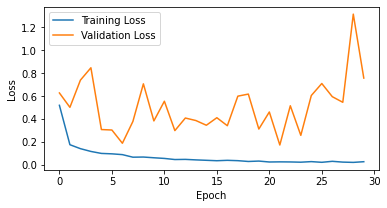

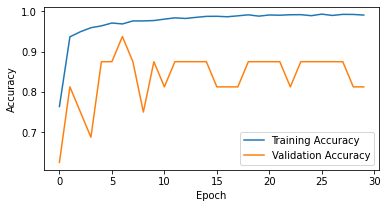

In [89]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the training history
loaded_history = np.load('models/cnn_7_history.npy', allow_pickle=True).item()

# Plot the training loss and validation loss
plt.figure(figsize=(6,3))
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(6,3))
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()